In [3]:
import copy 
import numpy as np
import pandas as pd
import sys
sys.path.append("../src")
import anomaly_detection_MVP as ad

from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from keras.layers import Dropout, LSTM, RepeatVector, TimeDistributed, Input,Dense
from keras.utils import plot_model
from keras.models import Model,Sequential

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from copy import deepcopy

Using TensorFlow backend.


In [4]:
# Set plotting style, not essential
from jupyterthemes import jtplot
jtplot.style()
jtplot.style(ticks=True, grid=False, figsize=(24, 6))

In [5]:
def reshape_data_NN(X_norm, ntr, ntst, delay):
    # Log normalization
    features_set = []  
    labels = []  
    for i in range(delay, ntr+ntst+ delay):  
        features_set.append(X_norm[i-delay:i])
        labels.append(X_norm[i])

    features_set = np.array(features_set)
    labels = np.reshape(labels, (len(labels), 1))

    features_set = np.reshape(features_set, (features_set.shape[0],features_set.shape[1]))  
    return(features_set, labels)

def niceplot(test, predictions, highlights = None):
    plt.plot(test, label = 'Real counts')
    plt.plot(predictions, color='g', label = 'Model counts')
    plt.xlabel('Hour')
    plt.ylabel('Hourly Count')
    if highlights is not None:
        plt.plot(np.arange(len(test))[highlights], np.zeros(len(test))[highlights], 'ro', label = 'highlights')
    plt.legend()
    plt.show()
    
def diffplot(test, predictions, threshold = None):
    diff = np.ravel(test) - np.ravel(predictions)
    plt.plot(diff, 'y', label = 'difference')
    plt.legend()
    print("Mean diff: %.2f, Mean Abs Diff: %.2f, Std of Diff: %.2f" %(np.mean(diff), np.mean(abs(diff)), np.std(diff, ddof = 1)))
    print("Mean %% abs Diff: %.2f %%"%(100*np.mean(np.abs(diff)/test)))
    plt.xlabel('Hour')
    plt.ylabel('Hourly Count')
    if threshold:
        over_thresh = np.where(abs(diff) > threshold)[0]
        plt.plot(np.arange(len(diff))[over_thresh], diff[over_thresh], 'ro')
    plt.show()

def corrupt(X_normlog, ntr, doa):
    """ generates artificially corrupted timeseries form a normal time series.
        The function only corrput points in the test set (thus after ntr).
        doa indicates the duration of anomalies that one wants to introduce (usually the duration of a period).
    """
    X_corrupted_normlog = deepcopy(X_normlog)
    X_corrupted_normlog[ntr + 2*doa: ntr+ 2*doa+ doa] = 1.5  # High continuous count for a day
    X_corrupted_normlog[ntr + 4*doa: ntr+ 4*doa+ doa] = -1  # Low continuous count for a day
    X_corrupted_normlog[ntr + 6*doa: ntr+ 6*doa+ doa] *= 1.6      # Higher than average day
    X_corrupted_normlog[ntr + 8*doa: ntr+ 8*doa+ doa] *=0.1    # Lower than average day
    X_corrupted_normlog[ntr + 10*doa+12] = 2.0  # High hourly count (spike)
    X_corrupted_normlog[ntr + 12*doa+12] = -1   # Low hourly count (trench)
    
    anomalies_index = np.zeros(ntest, dtype = 'bool')
    anomalies_index[2*doa-doa:2*doa] = True
    anomalies_index[4*doa-doa:4*doa] = True
    anomalies_index[6*doa-doa:6*doa] = True
    anomalies_index[8*doa-doa:8*doa] = True
    anomalies_index[10*doa+12-doa] = True
    anomalies_index[12*doa+12-doa] = True

    return X_corrupted_normlog, anomalies_index

# Import real count data

In [30]:
real_data = pd.read_csv('../data/aggregatedCounts2016.csv', sep=',', names = ['locid', 'devid', 'time', 'counts'], skiprows = [0])
print("locid possible values : ", set(real_data['locid']))
loc_id = 12
T = np.array(real_data.loc[real_data['locid'] == loc_id, 'time'])
X = np.array(real_data.loc[real_data['locid'] == loc_id, 'counts'])

# Create linearly normalized data
mu_X = np.mean(X)
std_X = np.std(X, ddof = 1)
X_norm =  (X - mu_X)/std_X

# Create log normalized data
X_log = np.log(X+1)
mu_log = np.mean(X_log)
sig_log = np.std(X_log)
X_normlog = (X_log - mu_log) / sig_log

# Also generate artificially corrupted data


locid possible values :  {2, 36, 10, 12, 44, 57}


# MVP anomaly detection

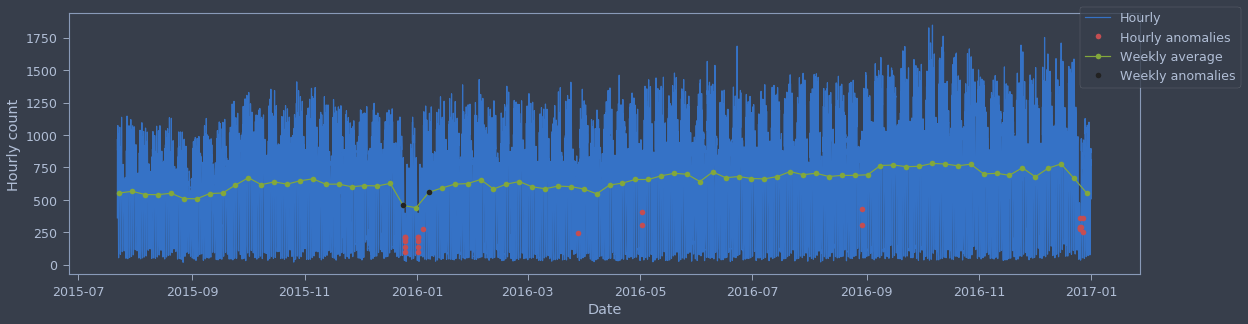

In [31]:
start_hour = 0
end_hour = -1
data_loc2 = {}
data_loc2['time'] = T[start_hour:end_hour]
data_loc2['counts'] = X[start_hour:end_hour]
a = ad.AnomalyDetection(data_loc2)
a.get_all_anomalies(0.2, 5, 5.0)
a.plot()

# Clustering methods
Clustering methods detect anomalies as points that are far away from the cluster's centroids.
They require a clustering algorithm, a metric to define distance from clusters, and a threhsold which defines anomalies. 

## Isolation forest
The method is based on the supposition that anomalies are few and different from everything else in the dataset.
The expected number of anomalies must be set a-priori. This means that this method always yields a certain number of anomalies, whether the dataset has none, few or many.
For the above reason this method should not be considered.

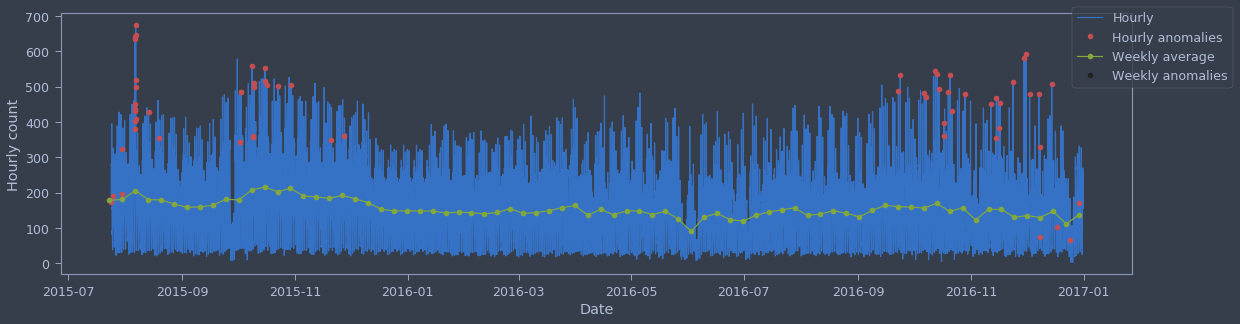

In [6]:
weeks = len(X)//168
X_reshape_1 = np.reshape(X[:weeks*7*24], (weeks, 7, 24))
weekday_4d = np.tile(np.repeat(np.arange(7), 24), weeks)/7
hour_4d =  np.tile(np.tile(np.arange(24), 7), weeks)/24
week_4d = np.repeat(np.repeat(np.arange(weeks), 7), 24)/weeks
counts_4d = np.ravel(X_reshape_1)
data_4d = np.vstack((counts_4d/2, week_4d, weekday_4d, hour_4d)).T

model =  IsolationForest(contamination=0.005, behaviour='new')
model.fit(data_4d) 
forest_anomalies_index = model.predict(data_4d)

forest_anomalies = np.zeros(len(real_data['counts'][:weeks*7*24]), dtype = 'bool')
forest_anomalies[np.where(forest_anomalies_index == -1)[0]] = 1
b = copy.deepcopy(a)
b.a_h[:weeks*7*24] = forest_anomalies
b.a_w = None
b.plot()

# Data series modelling-based methods
Series modelling-based methods first try to reconstruct the time series, and then detect anomalies where the difference between the original and reconstructed signals is above a user-set threshold.

## AR (AutoRegressive) Model
This method, like any other prediction-based method, first builds and fits a predictor model to the available past hourly count data, then uses the difference between the observed new data and the model prediction in order to decide when anomalies occur.
One of the simplest models one can build is the Autoregressive (AR) model, which uses the value of the last p hourly counts in order to infer the current hourly count. An AR model prediction $f$ at the time $t$ is calculated as:
$$ft = a_0 + a_1 \cdot  y_{t-1}+ a_2 \cdot y_{t-2} + \dots + a_p \cdot y_{t-p}$$
Where $y_t$ is the hourly count at time $t$ and $a_i$ are the weights of the model, which must be learned through fitting to existing data. Fitting is done by maximising the likelihood through a solver (e.g. Newton-Raphson, conjugate-gradient, etc.).
The method can learn trends which are up to $p$ long, therefore learning weekly behaviours requires fitting 168 (24*7) parameters, which is not trivial.
Moreover, the model is not really suited for seasonal data.

Lag: 25


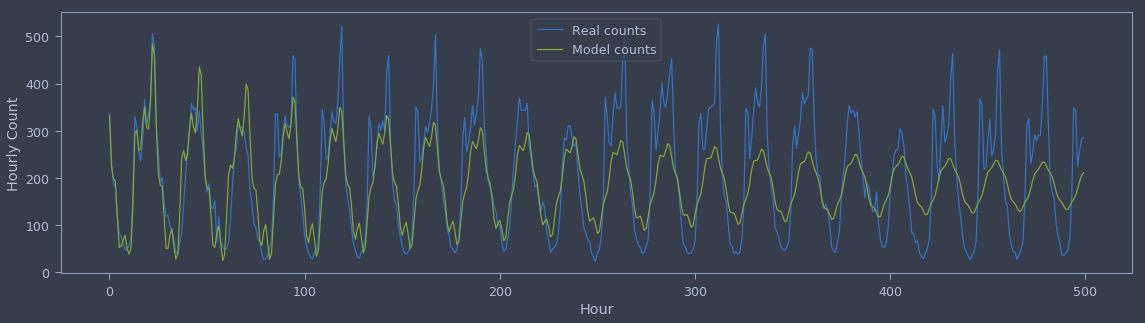

Mean diff: 17.03, Mean Abs Diff: 62.83, Std of Diff: 80.99
Mean % abs Diff: 51.71 %


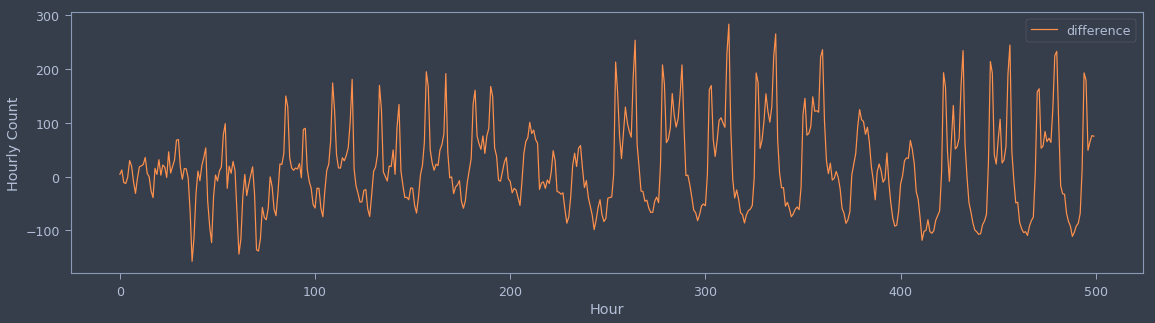

In [7]:
ntr = 2000
ntst = 500
train, test = X[0:ntr], X[ntr:ntr+ntst]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# plot results
niceplot(test, predictions)
diffplot(test, predictions)

## ARIMA (Auto Regressive Moving Average) Model
Similar to the previous method, but AR prediction is swapped for the more complex and powerful ARIMA prediction. ARIMA models are characterized by three values: $p, d, q$.
d indicates the number of differentiations that have to be made before modelling: $d=0$ means none, and the modelled value is the actual count values, $d=1$ means modelling the variation from the previous hourly count (“velocity”), $d=2$ is modelling the variation of the variation (“acceleration”).
p behaves exactly as in the AR model, and indicates the number of lags to be used in prediction.
q indicates the number of lags to be used when evaluating moving average: when predicting at time $t$ we include the errors the prediction made on times $t-1, \dots, t-q$. This is the MA part of the model. 
The model is more refined, but again not suited for seasonal data.


Lag: 3


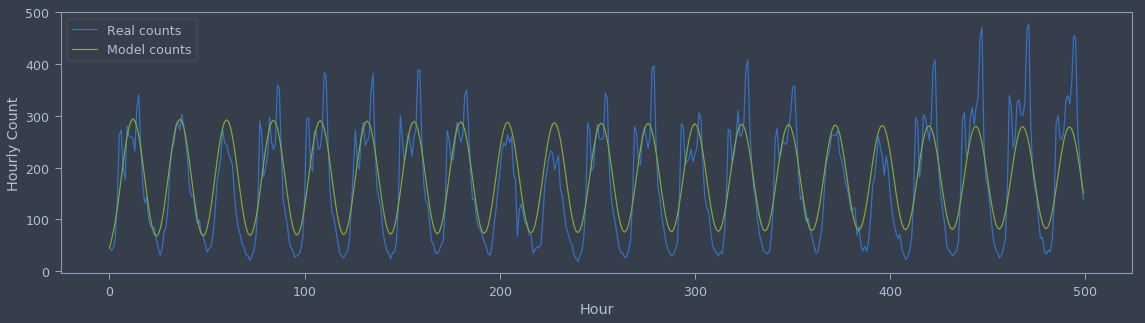

Mean diff: -11.73, Mean Abs Diff: 46.68, Std of Diff: 58.25
Mean % abs Diff: 50.07 %


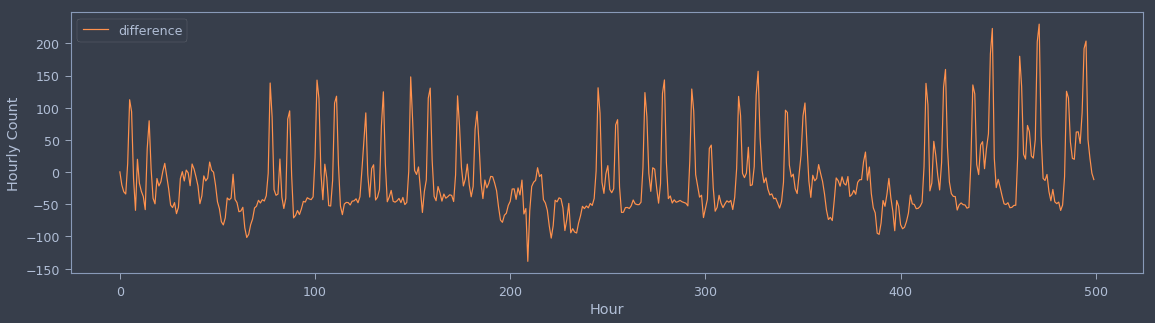

In [17]:
ntr = 1000
ntst = 500
train, test = X[0:ntr], X[ntr:ntr+ntst]
model = ARIMA(train, order = (3, 0, 3))
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# plot results
niceplot(test, predictions)
diffplot(test, predictions)

## SARIMA (Seasonal AutoRegressive Integrated Moving Average) Model

This is the obvious evolution of ARIMA for seasonal data, where 4 additional parameters are added to the model: $P, D, Q, m$. Here $P, D, Q$ are the seasonal counterparts to the $p, d, q$ values of the ARIMA model, while $m$ indicates how long a seasonal period is. 
Since we want to enforce our hourly count predictions to be positive, it makes sense to forgo the differentiation of data and set both d and D to be zero by default. This makes the model a SARMA model.
Given this assumption, the prediction for an hourly count at time $t$ is given by:
$$f_f = a_0 + a_1\cdot y_{t-1} \dots + a_p \cdot y_{t-p} - b_1\cdot e_{t-1} - … - b_q \cdot e_{t-q} + A_0 + A_1\cdot y_{t-m} \dots + A_P \cdot y_{t-Pm} - B_1 \cdot e_{t-m} \dots - B_q \cdot e_{t-mQ}$$
where $e_i$ is the error incurred by the model while predicting at time $i$, $a$ are the weights belonging to the non-seasonal autoregressive terms, $b$ the weights belonging to the non-seasonal moving average, A the weights belonging to the seasonal autoregressive terms and B the weights belonging to the seasonal moving average.
All these weights are optimised during fitting through a maximisation of the likelihood.
The only parameter set which yields a decent result and does not cause python to return a MemoryError is the following: (1, 0, 0) (1, 0, 1, 24). This is unfortunate, as a period of 168 (24*7) would be more suited to the task at hand; the fact that we are limited to a periodicity of 24 makes the model not sensitive to weekly trends, as can be observed below.


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


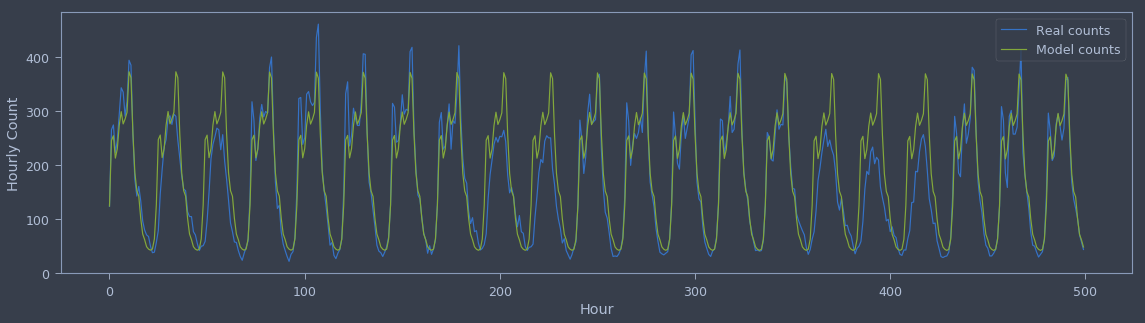

Mean diff: -14.22, Mean Abs Diff: 31.03, Std of Diff: 46.10
Mean % abs Diff: 27.34 %


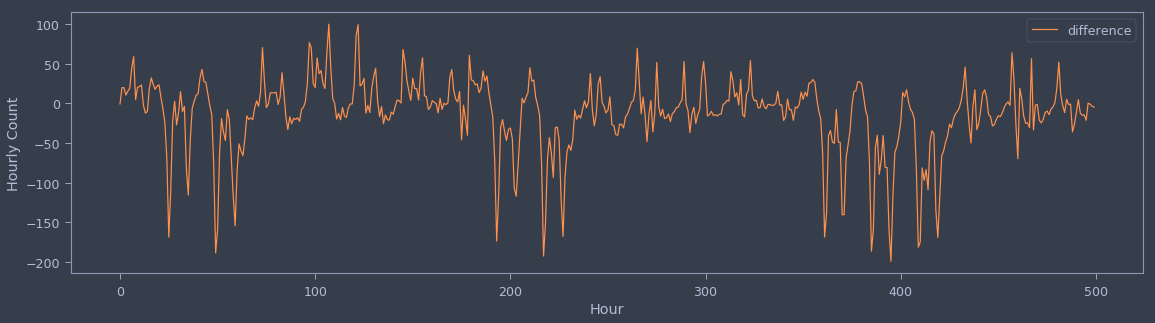

In [18]:
ntr = 500
ntst = 500
train, test = X[0:ntr], X[ntr:ntr+ntst]
# train autoregression
model = sm.tsa.statespace.SARIMAX(train, order = (1, 0, 1), seasonal_order = (1, 0, 1, 24))
model_fit = model.fit()
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# plot results
niceplot(test, predictions)
diffplot(test, predictions)

## LSTM RNN with no handcrafted input features
Recurrent neural networks are often used to predict time series. Their internal structure is such that outputs at time t depend from inputs and from the outputs at previous times.
This first example displays a Long Short-Time Memory RNN which uses as input features all of the hourly counts of the week before the predicted time. It is composed of three LSTM layers with a 0.2 dropout.
These input features are very redundant and most likely not optimal, and therefore the RNN takes a long time to train even with few data.

In [19]:
ntr = 500
ntst = 500
delay = 168 # How many hourly counts before the target are used as features

features_set, labels = reshape_data_NN(X_normlog, ntr, ntst, delay)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

X_train = features_set[:ntr]
X_test  = features_set[ntr:]

Y_train = labels[:ntr]
Y_test  = labels[ntr:] 

In [20]:
# Create model
rnn1 = Sequential()  
rnn1.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))  
rnn1.add(Dropout(0.2))
rnn1.add(LSTM(units=50, return_sequences=True))  
rnn1.add(Dropout(0.2))
rnn1.add(LSTM(units=50))  
rnn1.add(Dropout(0.2))  
rnn1.add(Dense(units = 1))  
rnn1.compile(optimizer = 'adam', loss = 'mean_squared_error')  

rnn1.fit(X_train, Y_train, validation_split=0.33, epochs=50, batch_size=32, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


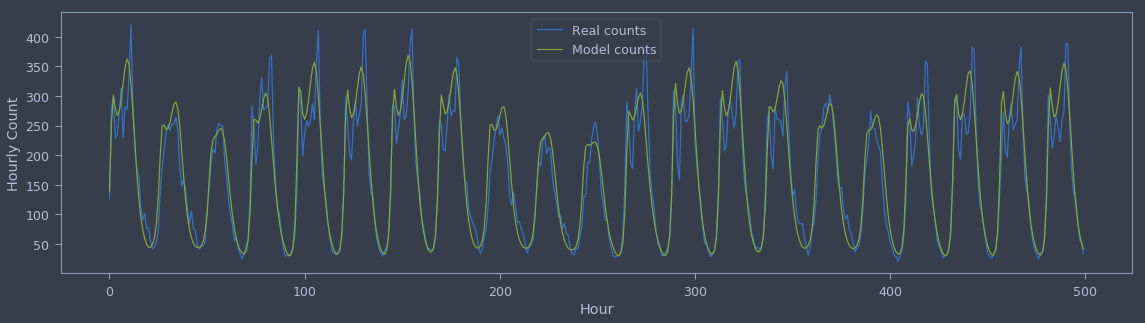

Mean diff: -8.70, Mean Abs Diff: 28.16, Std of Diff: 38.97
Mean % abs Diff: 30.25 %


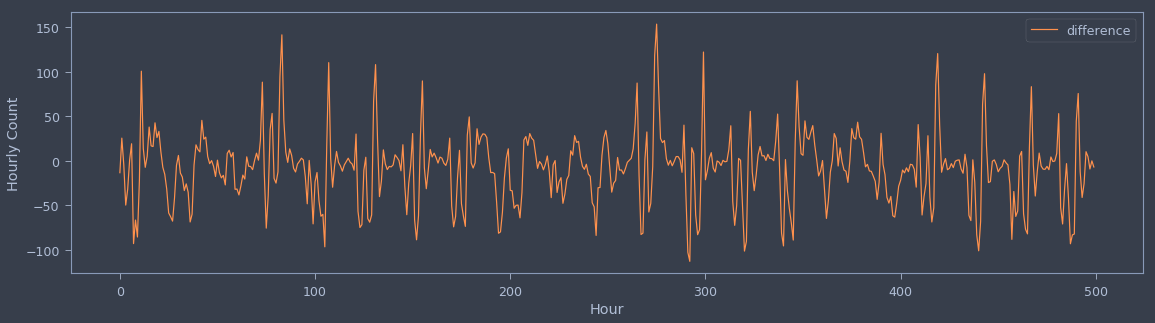

In [21]:
# Predict on unseen data
T_test = rnn1.predict(X_test)

# Transform back to hourly counts and plot
predictions = np.exp(T_test * sig_log + mu_log)  -  1
test = np.exp(Y_test * sig_log + mu_log)  -  1
niceplot(test, predictions)
diffplot(test, predictions)

## LSTM RNN with handcrafted input features
I implemented a simple Long Short-Term Memory neural network to use as a predictor of hourly counts. The input features that were fed to the model are the following:

1) Last hour’s count

2) Second last hour’s count

3) Third last hour’s count

4) Hour of the day

5) Day of the week

6) Average hourly count for the last week

7) Hourly count at the same time last week

The model so build is composed of 3 LSTM layers, with 50 neurons each and a dropout rate of 0.2, which are followed by a fully connected dense layer that ends with a single output (the prediction for the next hourly count). To train the model I used an ADAM optimiser and the mean squared error as the loss metric.
The model was trained for 60 epochs with batch size 32 and using 10000 training points.
The count data was log-normalized before training.

In [39]:
ntr = 1000
ntst = 500
delay = 3 # HOw many hourly counts before the target are used as features

# Create useful variables to be used as handcrafter features
T_datetime = [datetime.strptime(i, "%Y-%m-%d %H:%M:%S.%f") for i in T]
hour_of_day = np.array([i.hour for i in T_datetime])
day_of_week = np.array([i.weekday() for i in T_datetime])
weekly_average = np.array([ np.mean(X[i-168:i]) for i in range(168, len(X_normlog))])
weekly_log_average = np.log(weekly_average)
mu_w = np.mean(weekly_log_average)
std_w = np.std(weekly_log_average)
weekly_norm_average = (weekly_log_average - mu_w)/std_w

# Create the features to use as input
start = 0
features_set = []  
labels = []  
for i in range(delay, ntr+ntst+delay):  
    feature = []
    for t in range(1, delay+1):
        feature.append((X_norm[start+i-t]))
    feature.append(weekly_norm_average[start+i-168])
    feature.append(hour_of_day[start+i]/12-11.5/12)
    feature.append(day_of_week[start+i]/7-3/7)
    feature.append(X_norm[start+i-168])
    features_set.append(feature)
    labels.append(X_norm[start+i])
    
features_set = np.array(features_set)
labels = np.array(labels)

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

X_train = features_set[:ntr]
X_test  = features_set[ntr:]

Y_train = labels[:ntr]
Y_test  = labels[ntr:] 

In [23]:
# Build model
rnn2 = Sequential()  
rnn2.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))  
rnn2.add(Dropout(0.2))
rnn2.add(LSTM(units=50, return_sequences=True))  
rnn2.add(Dropout(0.2))
rnn2.add(LSTM(units=50))  
rnn2.add(Dropout(0.2))  
rnn2.add(Dense(units = 1))  
rnn2.compile(optimizer = 'adam', loss = 'mean_squared_error')  

# Fit model
rnn2.fit(features_set, labels, validation_split=0.33, epochs=60, batch_size=32, verbose=0)

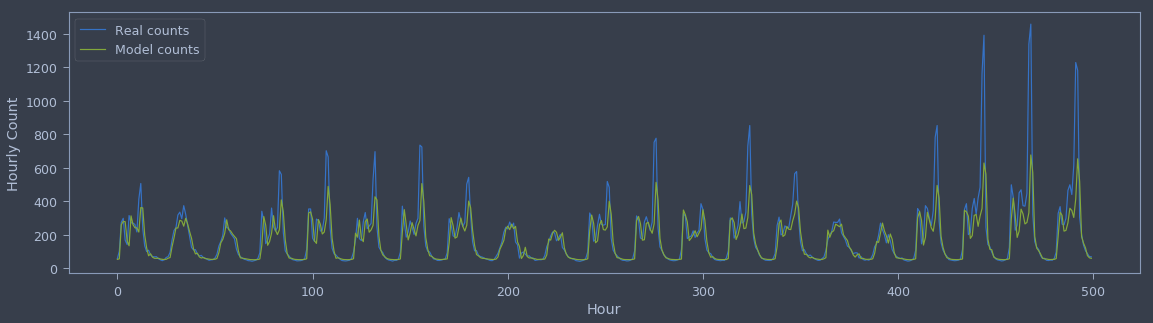

Mean diff: 26.76, Mean Abs Diff: 55.32, Std of Diff: 119.84
Mean % abs Diff: 21.17 %


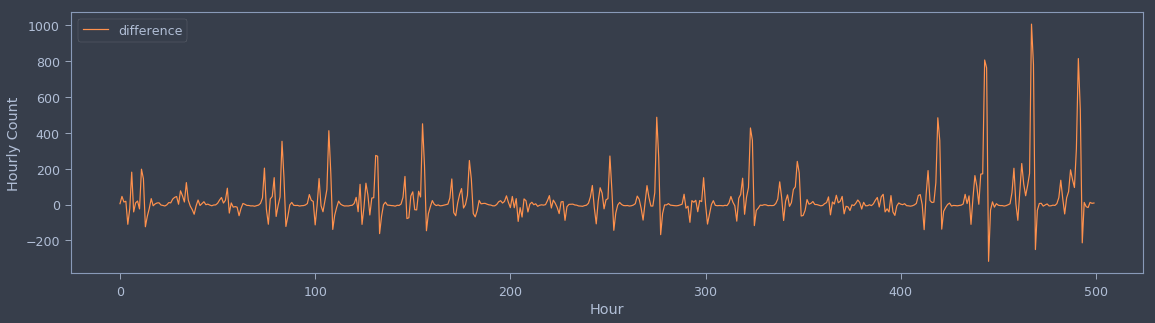

In [51]:
# Add some artificial anomalies to test data
X_test = deepcopy(features_set[ntr:])
# X_test[90:120] = -1.5
# X_test[0][15:17] = -1.5
# X_test[27] = 2.5

# Predict on unseen data
T_test = rnn2.predict(X_test)

# Transform back to hourly counts and plot
predictions = np.exp(T_test * sig_log + mu_log)  -  1
test = np.exp(Y_test * sig_log + mu_log)  -  1
niceplot(test, predictions)
diffplot(test, predictions)

## Simple Autoencoder
An autoencoder is an algorithm based on neural networks that is composed of two parts: and encoder and a decoder. The autoencoder takes an input, which is typically high-dimensional, and recasts it into a low-dimensional object. This object is then taken as an input by the decoder, which tries to reconstruct the initial high-dimensional input. All of this is trained by comparing the initial inputs to the encoded-decoded ones.
This algorithm may be useful for anomaly detection as anomalies should be not easily encoded; the encoded-decoded signal would therefore be anomaly-free. Applying then a difference between the original signal and the auto-encoded one would highlight anomalies.


In [52]:
ntr = 10000
ntest = 1000
delay = 168
encoding_dim=64 # Dimensionality of the encoder output

# Get features to use as inputs and outputs
features_set, labels = reshape_data_NN(X_normlog, ntr, ntest, delay)

# Separate into training and test set
X_train = features_set[:ntr]
X_test  = features_set[ntr:]

# Build model
input_dim=X_train.shape[1]
encoding_dim=64
compression_factor=float(input_dim/encoding_dim)

autoencoder=Sequential()
autoencoder.add(Dense(encoding_dim, input_shape=(input_dim,),activation='linear'))
autoencoder.add(Dense(input_dim,activation='linear'))
input_img=Input(shape=(input_dim,))
encoder_layer=autoencoder.layers[0]
encoder=Model(input_img,encoder_layer(input_img))
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train model
autoencoder.fit(X_train,X_train,epochs=50, batch_size=256, shuffle=True, validation_data=(X_test,X_test), verbose = 0)

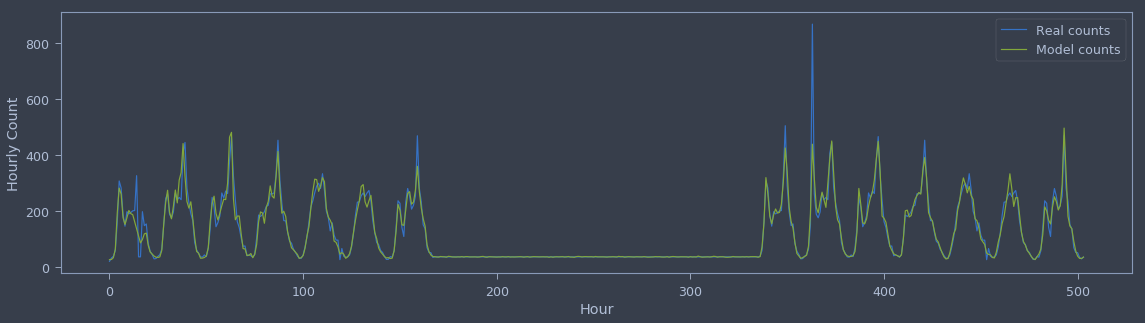

Mean diff: 1.14, Mean Abs Diff: 13.04, Std of Diff: 29.73
Mean % abs Diff: 8.85 %


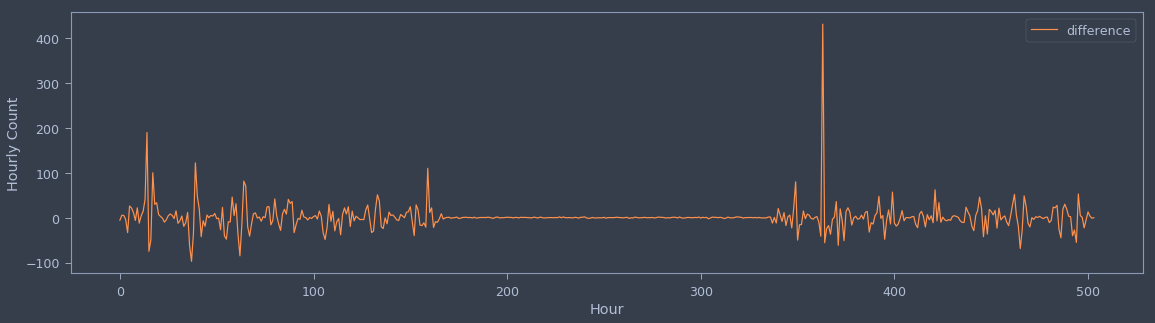

In [53]:
weeks_to_display=3
# Add some artificial anomalies to test data
X_test[1] = -1.5
X_test[0][15:17] = -1.5
X_test[2][27] = 2.5

# Predict
decoded_seq=autoencoder.predict(X_test)

# Transform data back into counts
dec_count = np.exp(decoded_seq * sig_log + mu_log)  -  1
test_count = np.exp(X_test * sig_log + mu_log)  -  1

# Keep only non-redundant data (this is due to how data is processed)
dec = np.zeros(168*weeks_to_display)
test = np.zeros(168*weeks_to_display)
for i in range(weeks_to_display):
    dec[i*168:(i+1)*168] = dec_count[i]
    test[i*168:(i+1)*168] = test_count[i]

# Plot
niceplot(test, dec)
diffplot(test, dec)

## Reconstruction LSTM Autoencoder
This model combines an autoencoder and two LSTM layers, creating what is called a "seq2seq" neural network.
It takes temporal series as inputs and predicts the same temporal series while autoencoding. This can be also used as a "denoiser" for noisy data.
The anomaly detection module will have a trained Reconstruction LSTM autoencoder, and then pass the observed daily counts to it. The autoencoder then tries to reconstruct the temporal sequance, and if it fails it means that the observed hourly couunt patter was not lreant, and therefore it can be called an anomaly.

The inputs are sets of 24 hours, this particular NN is trained on sequences that last 24 hours and start from any hour of the day. The NN then predicts the same 24 hours.

In [450]:
ntr = 5000
ntest = 1000
delay = 24

features_set, labels = reshape_data_NN(X_normlog, ntr, ntest, delay)
features_set = np.reshape(features_set, (ntr+ntest, delay, 1))

X_train = features_set[:ntr]
X_test  = features_set[ntr:]

lstm_autoenc_2 = Sequential()
lstm_autoenc_2.add(LSTM(50, activation='linear', input_shape=(delay,1)))
lstm_autoenc_2.add(RepeatVector(delay))
lstm_autoenc_2.add(LSTM(50, activation='linear', return_sequences=True))
lstm_autoenc_2.add(TimeDistributed(Dense(1)))
lstm_autoenc_2.compile(optimizer='adam', loss='mse')

In [451]:
lstm_autoenc_2.fit(X_train,X_train,epochs=100, batch_size=64, shuffle=True, validation_data=(X_test,X_test), verbose = 0)

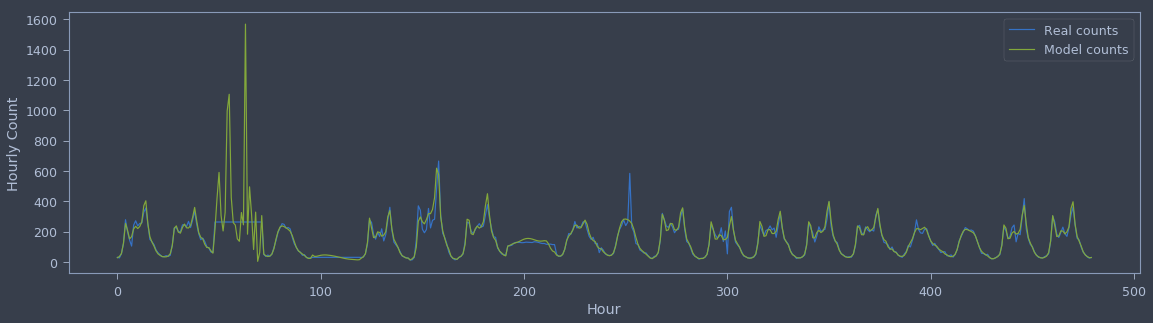

Mean diff: -7.92, Mean Abs Diff: 24.50, Std of Diff: 87.40
Mean % abs Diff: 14.83 %


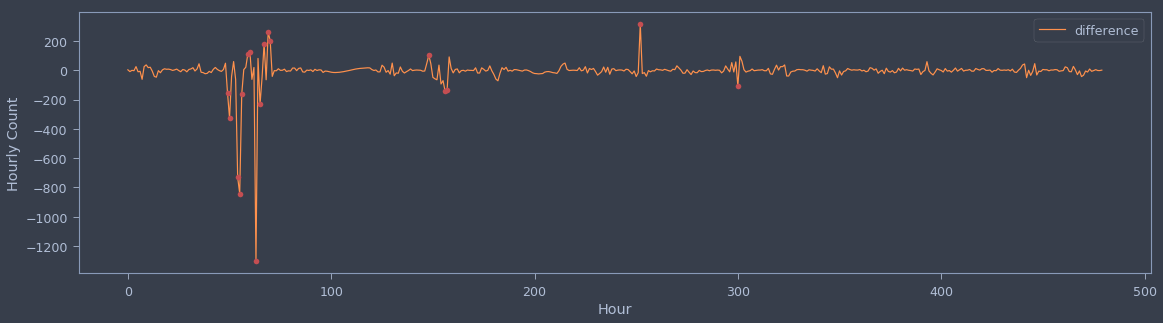

In [462]:
# Test on non-anomalous data
days_to_display=20

# Add some artificial anomalies to test data
X_test_ = deepcopy(features_set[ntr + 10:])
X_test_[2*delay][:] = 1.0  # High continuous count for a day
X_test_[4*delay][:] = -1.7  # Low continuous count for a day
X_test_[6*delay] *= 1.6      # Higher than average day
X_test_[8*delay][:] *=0.1    # Lower than average day
X_test_[10*delay][12] = 2.0  # High hourly count (spike)
X_test_[12*delay][12] = -1   # Low hourly count (trench)

# Predict
decoded_seq=lstm_autoenc_2.predict(X_test_)

# Transform outputs into hourly counts
dec_count = np.exp(decoded_seq * sig_log + mu_log)  -  1
test_count = np.exp(X_test_ * sig_log + mu_log)  -  1

# Get the right data
# This is necessary because the NN predicts the 24 hours starting from any  hour of the day. Therefore, to plot a realistic tim series, 
# we need to get a prediction every 24 hours, since every prediction is 24 hours long.
dec = np.zeros(delay*days_to_display)
test = np.zeros(delay*days_to_display)
for i in range(days_to_display):
    dec[i*delay:(i+1)*delay] = np.reshape(dec_count[i*delay][:], delay)
    test[i*delay:(i+1)*delay] = np.reshape(test_count[i*delay][:], delay)

niceplot(test, dec)
diffplot(test, dec, 100)

(1, 24, 1) (1, 24, 1)


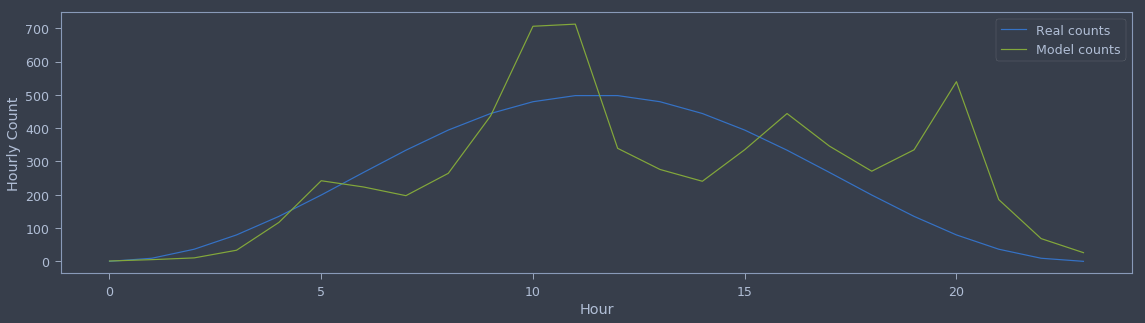

Mean diff: -25.16, Mean Abs Diff: 111.49, Std of Diff: 152.87
Mean % abs Diff: inf %


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


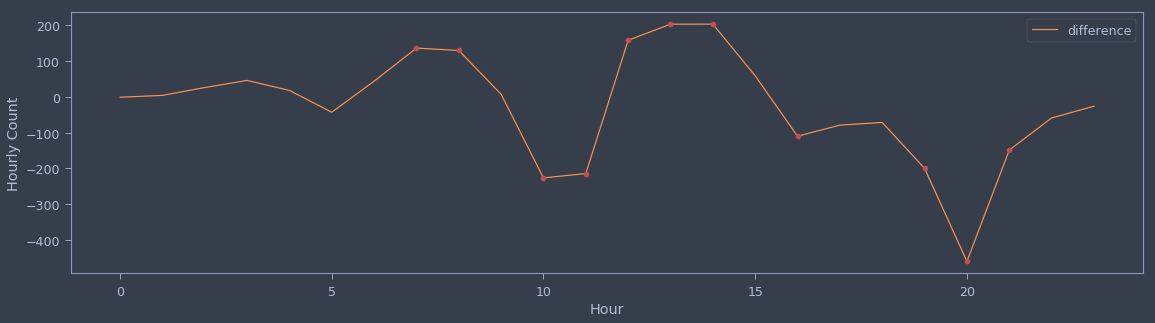

In [218]:
fake_data = 500*np.sin(np.linspace(0, np.pi, 24))**2
fake_data = np.reshape(fake_data, (1, 24, 1))
# Create log normalized data
fake_log = np.log(fake_data+1)
m = np.mean(X_log)
s = np.std(X_log)
fake_normlog = (fake_log - m) / s
pred_log=lstm_autoenc_2.predict(fake_normlog)


fake_count = np.exp(fake_normlog * s + m)  -  1
fake_pred = np.exp(pred_log * s + m)  -  1
niceplot(fake_count[0], fake_pred[0])
diffplot(fake_count[0], fake_pred[0], 100)

## Prediction LSTM Autoencoder
This model combines an autoencoder and two LSTM layers, creating what is called a "seq2seq" neural network.
It takes temporal series as inputs and predicts the next value of the time series.
The anomaly detection module will have a trained Reconstruction LSTM autoencoder, and then pass the observed daily counts to it. The autoencoder then tries to predict the next hour and if it fails it means that the observed hourly couunt patter was not learnt, and therefore it can be called an anomaly.

The inputs are sets of 24 hours, this particular NN is trained on sequences that last 24 hours and start from any hour of the day. The NN then predicts the next hourly count.

In [479]:
# Set parameters

ntr = 2000
ntest = 500
delay = 24

# Get data in the correct shape
features_set, labels = reshape_data_NN(X_normlog, ntr, ntest, delay)
features_set = np.reshape(features_set, (ntr+ntest, delay, 1))
labels = np.reshape(labels, (ntr+ntest, 1, 1))
X_train = features_set[:ntr]
X_test  = features_set[ntr:]
Y_train = labels[:ntr]
Y_test =  labels[ntr:]

In [480]:
# Build model
lstm_autoenc_3 = Sequential()
lstm_autoenc_3.add(LSTM(100, activation='linear', input_shape=(delay,1)))
lstm_autoenc_3.add(RepeatVector(1))
lstm_autoenc_3.add(LSTM(100, activation='linear', return_sequences=True))
lstm_autoenc_3.add(TimeDistributed(Dense(1)))
lstm_autoenc_3.compile(optimizer='adam', loss='mse')

# Train model
lstm_autoenc_3.fit(X_train, Y_train, epochs=100, batch_size=64, shuffle=True, validation_data=(X_test,Y_test), verbose=1)

Train on 2000 samples, validate on 500 samples
Epoch 1/100
2000/2000 [==============================] - 9s 5ms/step - loss: 0.6704 - val_loss: 0.2401
Epoch 2/100
2000/2000 [==============================] - 1s 631us/step - loss: 0.1852 - val_loss: 0.1181
Epoch 3/100
2000/2000 [==============================] - 1s 638us/step - loss: 0.1242 - val_loss: 0.1000
Epoch 4/100
2000/2000 [==============================] - 1s 646us/step - loss: 0.1125 - val_loss: 0.0929
Epoch 5/100
2000/2000 [==============================] - 1s 644us/step - loss: 0.1025 - val_loss: 0.0833
Epoch 6/100
2000/2000 [==============================] - 2s 805us/step - loss: 0.0924 - val_loss: 0.0754
Epoch 7/100
2000/2000 [==============================] - 2s 832us/step - loss: 0.0860 - val_loss: 0.0654
Epoch 8/100
2000/2000 [==============================] - 2s 827us/step - loss: 0.0746 - val_loss: 0.0611
Epoch 9/100
2000/2000 [==============================] - 1s 679us/step - loss: 0.0703 - val_loss: 0.0631
Epoch 10/1

2000/2000 [==============================] - 1s 689us/step - loss: 0.0333 - val_loss: 0.0292
Epoch 79/100
2000/2000 [==============================] - 1s 658us/step - loss: 0.0322 - val_loss: 0.0292
Epoch 80/100
2000/2000 [==============================] - 1s 671us/step - loss: 0.0324 - val_loss: 0.0280
Epoch 81/100
2000/2000 [==============================] - 1s 674us/step - loss: 0.0327 - val_loss: 0.0287
Epoch 82/100
2000/2000 [==============================] - 1s 654us/step - loss: 0.0318 - val_loss: 0.0349
Epoch 83/100
2000/2000 [==============================] - 1s 664us/step - loss: 0.0322 - val_loss: 0.0294
Epoch 84/100
2000/2000 [==============================] - 1s 673us/step - loss: 0.0327 - val_loss: 0.0297
Epoch 85/100
2000/2000 [==============================] - 1s 661us/step - loss: 0.0312 - val_loss: 0.0285
Epoch 86/100
2000/2000 [==============================] - 1s 655us/step - loss: 0.0313 - val_loss: 0.0294
Epoch 87/100
2000/2000 [==============================] - 1

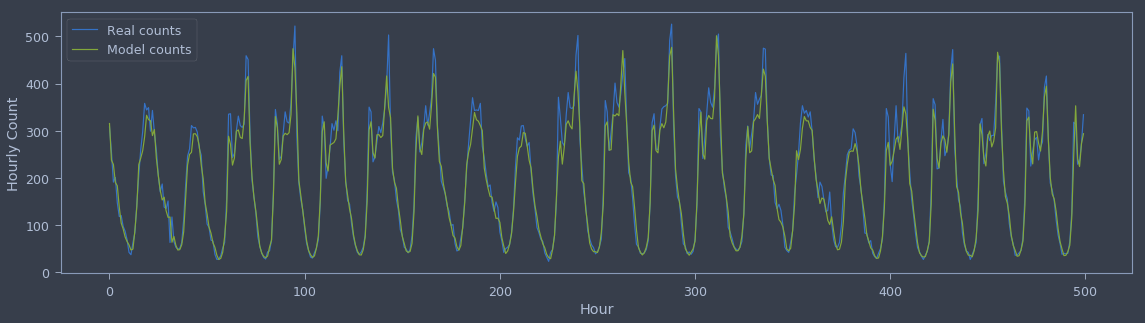

Mean diff: 8.20, Mean Abs Diff: 18.50, Std of Diff: 25.54
Mean % abs Diff: 10.27 %


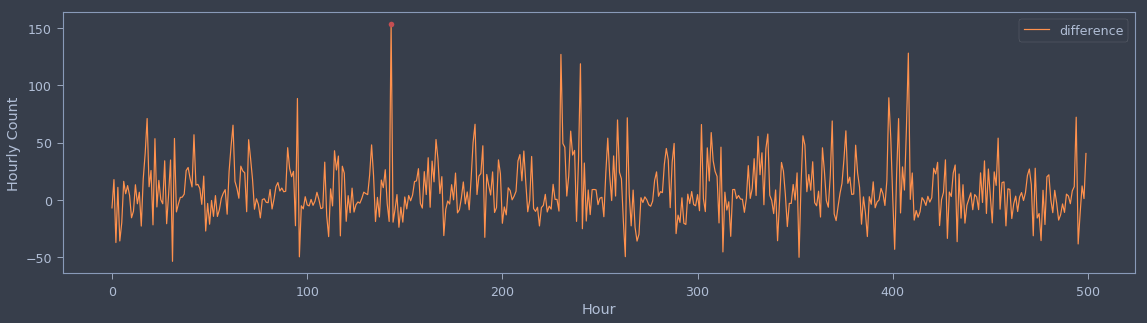

In [481]:
# Predict
pred_logcounts= lstm_autoenc_3.predict(X_test)

# Transform outputs into hourly counts
pred_counts = (np.exp(pred_logcounts * sig_log + mu_log)  -  1)[:,0,0]
test_counts = (np.exp(Y_test * sig_log + mu_log)  -  1)[:,0,0]

niceplot(test_counts, pred_counts)
diffplot(test_counts, pred_counts, 150)

### Test non-iteratevly on corrupted data

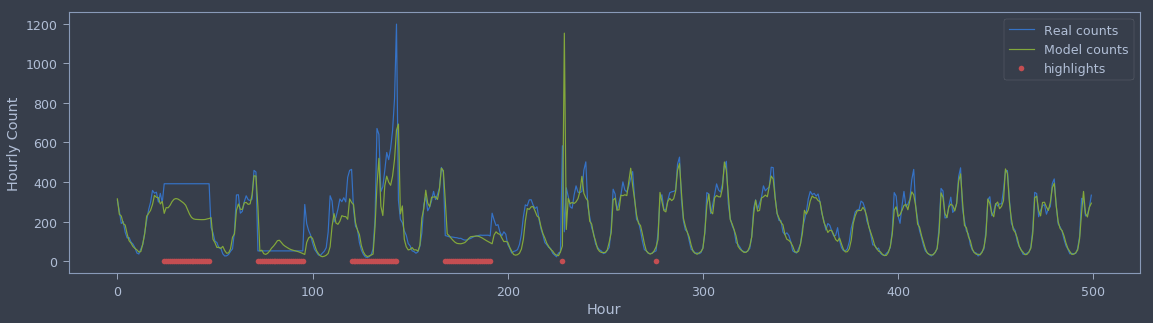

Mean diff: 18.72, Mean Abs Diff: 38.27, Std of Diff: 79.81
Mean % abs Diff: 19.65 %


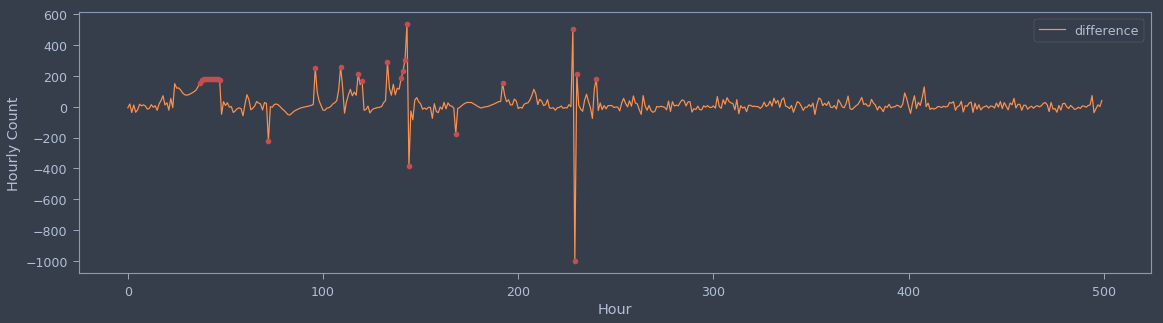

In [482]:
# Corrupt data artificially and then try to detect anomalies
# Add some artificial anomalies to test data

doa = 24 # duration of anomaly in hours
X_corrupted_normlog, anomaly_index = corrupt(X_normlog, ntr, doa)
features_set, labels = reshape_data_NN(X_corrupted_normlog, ntr, ntest, delay)
features_set = np.reshape(features_set, (ntr+ntest, delay, 1))
labels = np.reshape(labels, (ntr+ntest, 1, 1))

X_test_corrupted  = features_set[ntr:]
Y_test_corrupted =  labels[ntr:]

# Predict
pred_logcounts= lstm_autoenc_3.predict(X_test_corrupted)

# Transform outputs into hourly counts
pred_counts = (np.exp(pred_logcounts * sig_log + mu_log)  -  1)[:,0,0]
test_counts = (np.exp(Y_test_corrupted * sig_log + mu_log)  -  1)[:,0,0]

niceplot(test_counts, pred_counts, anomaly_index)
diffplot(test_counts, pred_counts, 150)

### Iterative hourly prediction using real data or predicted data, based on the presence of detected anomalies
The model predicts the next hourly count based on the 24 previous ones. If a count is detected as an anomaly, the predicted value is sobstituted to the real value in the inputs.

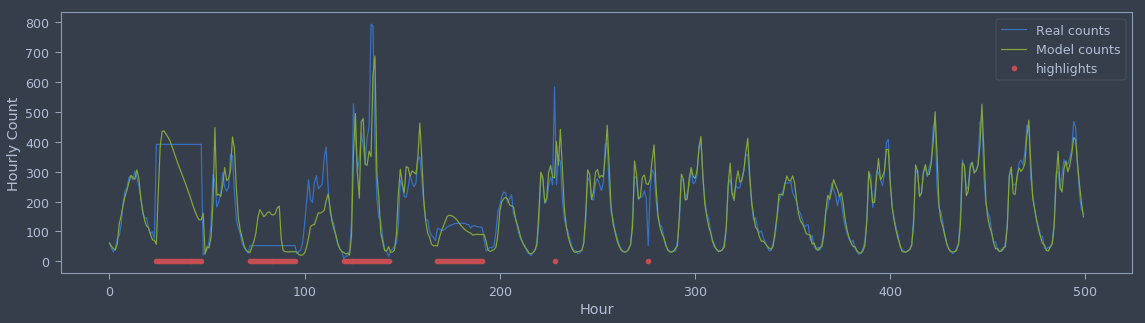

Mean diff: 3.28, Mean Abs Diff: 34.40, Std of Diff: 61.54
Mean % abs Diff: 24.58 %


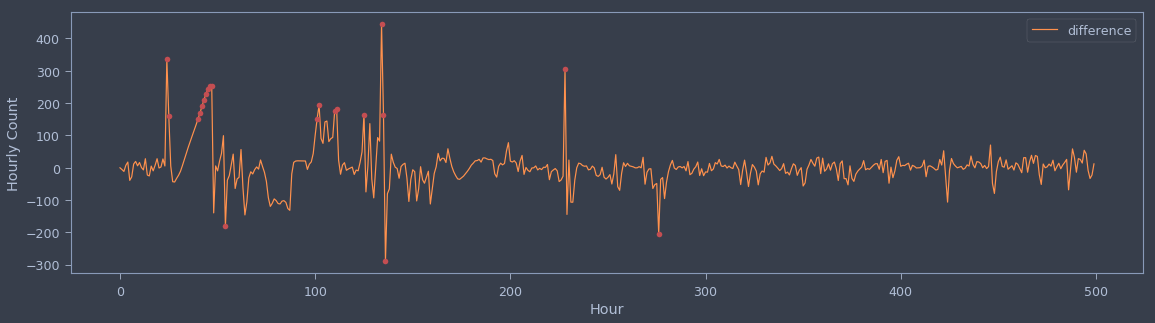

In [468]:
iterative_pred = np.zeros(ntest)
modified_input = deepcopy(X_test_corrupted)
test_counts = (np.exp(Y_test_corrupted * sig_log + mu_log)  -  1)[:,0,0]
threshold = 150
for i in np.arange(ntest):
    output = lstm_autoenc_3.predict(np.reshape(modified_input[i,:,0], (1, 24, 1)))
    iterative_pred[i] = (np.exp(output * sig_log + mu_log)  -  1)
    if (iterative_pred[i] - test_counts[i]) > threshold:
        for t in range(24):
            try:
                modified_input[i+1+t,23-t , 0] = pred
            except:
                pass            
niceplot(test_counts, iterative_pred, anomaly_index)
diffplot(test_counts, iterative_pred, 150)

### Use the predictor to impute missing data

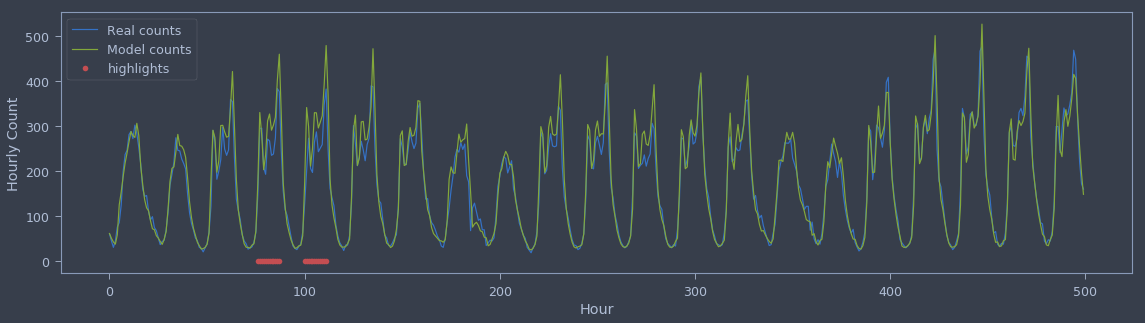

Mean diff: -7.35, Mean Abs Diff: 19.46, Std of Diff: 27.93
Mean % abs Diff: 12.43 %


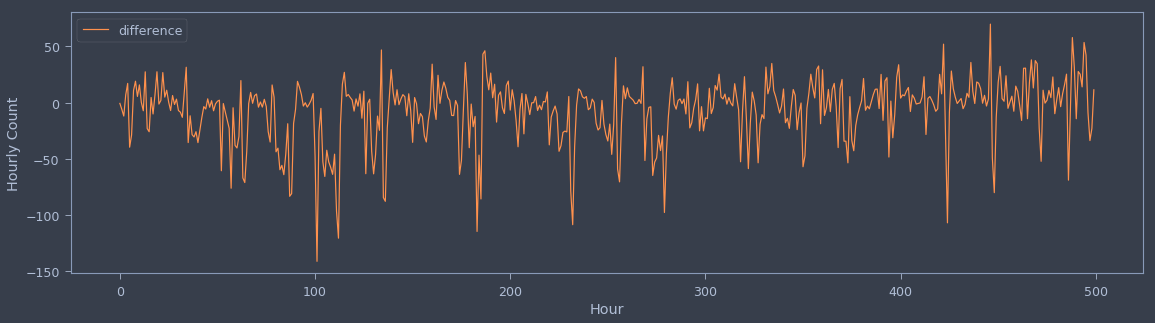

In [473]:
holey_data = deepcopy(X_normlog)
missing_data = np.zeros(len(holey_data), dtype = 'bool')
missing_data[ntr + 100: ntr + 112] = True
missing_data[ntr + 124: ntr + 136] = True

holey_data[missing_data] = np.nan

features_set, labels = reshape_data_NN(holey_data, ntr, ntest, delay)
features_set = np.reshape(features_set, (ntr+ntest, delay, 1))
copy_features_set = deepcopy(features_set)
labels = np.reshape(labels, (ntr+ntest, 1, 1))

X_test_holey  = features_set[ntr:]
Y_test_holey =  labels[ntr:]
count_holey = (np.exp(Y_test_holey * sig_log + mu_log)  -  1)

iterative_pred = np.zeros(ntest)
for i in range(ntest):
    pred = lstm_autoenc_3.predict(np.reshape(X_test_holey[i,:,0], (1, 24, 1)))
    iterative_pred[i] = (np.exp(pred * sig_log + mu_log)  -  1)
    if np.isnan(Y_test_holey[i]):
        for t in range(24):
            try:
                X_test_holey[i+1+t,23-t , 0] = pred
            except:
                pass
test_counts = (np.exp(Y_test * sig_log + mu_log)  -  1)[:,0,0]
      
niceplot(test_counts, iterative_pred, missing_data[ntr+24:ntr+ntest+24])
diffplot(test_counts, iterative_pred, 150)